<a href="https://colab.research.google.com/github/wellia/DeepLearning/blob/main/MNIST_MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SIT744 Assignment 1: Image Classification with Deep Feedforward Neural Network

*   Student Id: 220093302
*   Student Name: Wellia Lioeng



### Import libraries

In [ ]:
!pip install -q -U keras-tuner
!pip install -U tensorboard
!pip install umap-learn

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import pathlib
import shutil
import tempfile

import keras_tuner as kt

import umap.umap_ as umap

from tensorflow.keras.utils import plot_model
from tensorflow.keras.utils import to_categorical

from sklearn.model_selection import train_test_split

plt.rcParams['figure.figsize'] = (16, 10)
plt.rc('font', size=15)

     |████████████████████████████████| 96 kB 4.2 MB/s 
     |████████████████████████████████| 80 kB 5.9 MB/s 
     |████████████████████████████████| 1.1 MB 30.7 MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.1-py3-none-any.whl size=76564 sha256=6cee042e639d47c28138f83e835befe4aa04cce069346f102e5799038ce21d51
  Stored in directory: /root/.cache/pip/wheels/01/e7/bb/347dc0e510803d7116a13d592b10cc68262da56a8eec4dd72f
  Created wheel for pynndescent: filename=pynndescent-0.5.4-py3-none-any.whl size=52373 sha256=5faf5826ee0190bd74f839cd7d5e91680e8535a6287fb344b67e4eca396ac814
  Stored in directory: /root/.cache/pip/wheels/d0/5b/62/3401692ddad12324249c774c4b15ccb046946021e2b581c043
Successfully built umap-learn pynndescent


## Task 1 Load the data


In [ ]:
# Load data
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

print('Training size:', X_train.shape)
print('Training label size:', y_train.shape)

print('Test size:', X_test.shape)
print('Test label size:', y_test.shape)

Training size: (60000, 28, 28)
Training label size: (60000,)
Test size: (10000, 28, 28)
Test label size: (10000,)


## Task 2 Understand the data


Display 20 images from the train set in the form of 5x4 matrix.



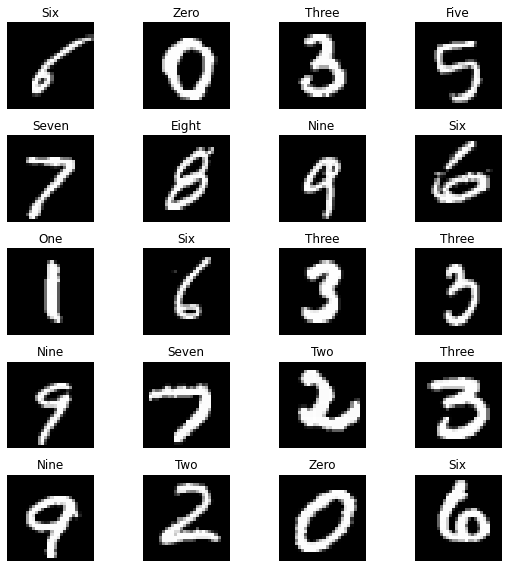

In [ ]:
labels_map = {0: 'Zero', 1: 'One', 2: 'Two', 3: 'Three', 4: 'Four',
              5: 'Five', 6: 'Six', 7: 'Seven', 8: 'Eight', 9: 'Nine'}
rows = 5
columns = 4
fig = plt.figure(figsize=(8, 8))

for i in range(1, columns * rows+1):
    data_idx = np.random.randint(len(X_train))
    img = X_train[data_idx].reshape([28, 28])
    label = labels_map[y_train[data_idx]]
    fig.add_subplot(rows, columns, i)
    plt.title(label)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
# Check numeric range of input
print("Training minimum value is {}, maximal value is {}".format(np.min(X_train), np.max(X_train)))

Training minimum value is 0, maximal value is 255


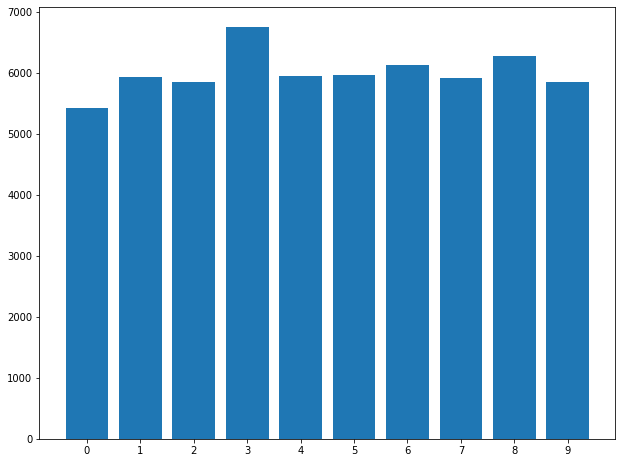

In [ ]:
# Check imbalanced data

import collections

counter=collections.Counter(y_train)
d = dict(counter)

labels =  list(labels_map.keys())

fig = plt.figure(figsize=(8, 6))
ax = fig.add_axes([0,0,1,1])
plt.bar(range(len(d)), list(d.values()), align='center')
plt.xticks(labels)
plt.show()

Result:

The MNIST training data is well balanced. The highest number of label is '3' and the lowest is '0'

In this assignment, I use MNIST - handwritten digits dataset from keras. It is used to classify handwritten digits. This dataset contains 60,000 training images and 10,000 testing images, formatted as 28 x 28 pixel monochrome images. The unique labels are 0, 1, 2, 3, 4, 5, 6, 7, 8, 9 in this dataset. 
<br/><br/>
The size of each image is 28 x 28 pixels in gray scale 1 byte/pixel, so the memory required for holding the training data is 60000 x 28 x 28 x 1 byte = 47,040,000 bytes = 44.86 mb
<br/><br/>
Pixel values are ranging from 0 to 255. We need to rescale it into values between 0 to 1. In neural network gradient descent, the rescalling makes the convergence is much faster than without it. In term of the label data, I use categorical_crossentropy loss, so I converted targets to categorical format.


Before I process the data. I divided data into Training - Validation - Test. Training data is use to train a model, validation data is used for estimation & tuning, and test data is used to evaluate a model. I separated the data at an early stage to avoid the data leakage

In [ ]:
# Set aside validation data
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

print('Training size now:', X_train.shape)
print('Training label size now:', y_train.shape)

print('Validation size:', X_val.shape)
print('Validation label size:', y_val.shape)

Training size now: (54000, 28, 28)
Training label size now: (54000,)
Validation size: (6000, 28, 28)
Validation label size: (6000,)


In [ ]:
# Normalization/Rescaling
def rescaling (image):
  return tf.cast(image, tf.float32) / 255

def convert (y):
  return to_categorical(y)

X_train = rescaling(X_train)
X_test = rescaling(X_test)
X_val = rescaling(X_val)

y_train = convert(y_train)
y_test = convert(y_test)
y_val = convert(y_val)

## Task 3 Construct an input pipeline

**Batch size**

In general, smaller batch sizes train slower but converge faster than the larger ones. I choose 128 batch size to build my first model based on common  practice for MNIST dataset. MNIST is categorized as a small training set, therefore batch size less than 200 is sufficient

**Shuffle**

For standard MINST single dataset, it might not necessary to shuffle. But it is a good practice to shuffle the data before training. Some data may contain certain artifacts. One of these artifacts is the order of the data. If the data is sorted, model might remember the data instead of learning. Another reason is If similar data points lie next to each other, it can lead to slow convergence. Another benefit of shuffling is reducing variance and overfit.

**Shuffle buffer**

Set the shuffle buffer to the full dataset size for true randomness. If the dataset is too big, a standard value is 1000 (depends on the system. In this assignment, the training size is 54000 (after take some for validation), so the buffer size is set to 54000

In case of validation and test data, there is no need to shuffle them

**Caching and prefetching**

Other settings in input pipelines are caching and prefetching. Prefecthing is added to increase the performance, the data for the next batch is ready which algorithm is processing the current batch.

I added caching for better performance. The data is ready in the memory

**Converting label data**

To work with categorical_crossentropy loss function, my targets must be one-hot encoded, so I converted label data using to_categorical() function from Keras utils library. If the label is '2' it will encode to [0 0 1 0 0 0 0 0 0 0]

In [ ]:
# Declare constants
BATCH_SIZE = 128
STEPS_PER_EPOCH = len(X_train)/BATCH_SIZE

In [ ]:
# Input pipelines

def input_pipelines(xTrain, yTrain, xVal, yVal, xTest, yTest, batchSize = BATCH_SIZE):
  BUFFER_SIZE = len(X_train)

  # Train dataset
  train_ds = tf.data.Dataset.from_tensor_slices((xTrain, yTrain))\
          .cache()\
          .shuffle(buffer_size=BUFFER_SIZE)\
          .batch(batch_size=batchSize)\
          .prefetch(tf.data.experimental.AUTOTUNE)

  # Validation dataset
  val_ds = tf.data.Dataset.from_tensor_slices((xVal, yVal))\
          .batch(batch_size=batchSize)\
          .cache()\
          .prefetch(tf.data.experimental.AUTOTUNE)

  # Test dataset
  test_ds = tf.data.Dataset.from_tensor_slices((xTest, yTest))\
          .batch(batch_size=batchSize)\
          .cache()\
          .prefetch(tf.data.experimental.AUTOTUNE)

  return train_ds, val_ds, test_ds

In [ ]:
train_ds, val_ds, test_ds = input_pipelines(X_train, y_train, X_val, y_val, X_test, y_test, BATCH_SIZE)

## Task 4 Construct a deep forward neural network


### Task 4.1 Setting up a model for training

Here is the basic model:

Sequential model with 3 layers:
*   tf.keras.layers.Flatten(input_shape=(28, 28)),
*   tf.keras.layers.Dense(128, activation='relu'),
*   tf.keras.layers.Dense(10, activation='softmax')

**Sequential model**:

I use The Sequential model because it's simplicty. In Keras, we can build a model with sequential or functional API. Sequential is a stack of layers, a current layer is connected to a previous and next layer. Using functional API, a layer can connect to any layers, it offers flexibility but also complexity.

**Input layer**

I add Flatten layer in the beginning, so our data which is 28x28 images is flatten into 1-dimension 784x1

**Hidden layer**:

I added only 1 hidden layer because one hidden layer is sufficient for the  MNIST data. 

The layer contains 128 nodes. It is based rules-of-thumb, the optimal size of the hidden layer is usually between the size of the input and size of the output layers.

I use ReLU activation for a hidden layer. ReLU is less susceptible to vanishing gradients than other common activation functions for a hidden layer such as Sigmoid and Tanh.

**Output layer**:

The output layer has 10 nodes as a reflection as 10 labels

I use softmax activation. The softmax function normalizes the outputs so that they sum to 1 so that they can be directly treated as probabilities over the output. We have 10 target labels, so we will have 10 output probabilities that will sum up to 1. 

**Loss function**:

I implemented categorical_crossentropy because this loss function can be used in multi-class classification tasks which a sample can only belong to one out of many possible categories. This loss function is suitable for MNIST case.

**Evaluation metric**:

I use accuracy metric for model evaluation. Accuracy is the ratio of number of correct predictions to the total number of input samples. 

When I set accuracy as a metric, for multi-class classification, categorical_accuracy will be used internally in Keras. (https://stackoverflow.com/questions/43544358/categorical-crossentropy-need-to-use-categorical-accuracy-or-accuracy-as-the-met)

**Optimizer**:

I use Adam optimiser because Adam is a popular algorithm in deep learning, it achieves good results fast. There are many research papers proving Adam is the best optimiser for majority of the problems such as in https://arxiv.org/abs/1609.04747, https://arxiv.org/abs/1502.03044 and other publications

Basic and final models are plotted using keras.utils.plot_model and show the details using model.summary()

**Learnable parameters**

Weights and biases are trainable parameters. To calculate the total number of learnable parameters:
- Input layer has no learnable parameters
- hidden layer = input nodes * output nodes + bias = 784 x 128 + 128 = 100,480 
- output layer = input nodes * output nodes + bias = 128 x 10 + 10 = 1,290

Total number of learnable parameters: 100,480 + 1,290 = 101,770

### Settings




In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd /content/drive/MyDrive/Colab Notebooks/

/content/drive/MyDrive/Colab Notebooks


In [ ]:
# Set up tensorboard logs
#!rm -rf ./logs/ # clear old logs if it's necessary
from datetime import datetime
import os
root_logdir = "/content/drive/MyDrive/logs"
run_id = datetime.now().strftime("%Y%m%d-%H%M%S")
logdir = os.path.join(root_logdir, run_id)

### User functions

In [ ]:
import seaborn as sns

# Function to create a callback function to set early stopping and tensorBoard
def get_callbacks(name, isLog=True):
  return [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20),
    tf.keras.callbacks.TensorBoard(logdir + "/" + name, histogram_freq=1, write_images=True)
  ]

# Function to compile and fit model 
histories = {}
def compile_and_fit(model, name, optimizer, max_epochs, batchSize=BATCH_SIZE, trainDs=train_ds):
  
  model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

  gradient_cb = get_callbacks(name)

  history = model.fit(
    trainDs,
    batch_size=batchSize,
    epochs=max_epochs,
    validation_data=val_ds,
    callbacks=gradient_cb,
    verbose=2)
  
  return history

# Function to visualize weights
def visualise_weights(layer_idx, model):

  # scatter plot of kernel weight
  n_components = 2

  filters, biases = model.layers[layer_idx].get_weights()

  data = model.layers[layer_idx].get_weights()[0] # only get weight kernel, not the bias

  umap_fit = umap.UMAP(random_state=42, n_components=n_components)
  umap_data = umap_fit.fit_transform(data)

  x = umap_data[:,0]
  y = umap_data[:,1]
  
  # violin plot of weight (kernel + bias)
  weights = model.get_weights()
  weight = weights[layer_idx].flatten().reshape(-1,1)

  # plot them
  fig = plt.figure(figsize=(15, 7))

  ax1 = plt.subplot(1, 2, 1)
  ax1.scatter(x, y)
  ax1.set_xlabel('Units')
  ax1.set_ylabel('Weight')
  ax1.title.set_text('Weight before fitting of layer ' + str(layer_idx))

  ax2 = plt.subplot(1, 2, 2)
  ax2 = sns.violinplot(y=weight, color='b')
  ax2.set_ylabel('Weight')
  ax2.title.set_text('Weight after fitting of layer ' + str(layer_idx))

  plt.show()

# set learning schedule
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
  0.001,
  decay_steps=STEPS_PER_EPOCH*1000,
  decay_rate=1,
  staircase=False)

# Function to return Adam optimizer with schedule learning rate
def get_optimizer():
  return tf.keras.optimizers.Adam(lr_schedule)

# Function to plot accuracy and loss
def plot_model_metric(model_history):
  fig = plt.figure(figsize=(15, 7))
  plt.title('Training vs Validation')

  ax1 = plt.subplot(1, 2, 1)
  ax1.plot(model_history.history['accuracy'])
  ax1.plot(model_history.history['val_accuracy'])
  ax1.set_xlabel('Epochs')
  ax1.set_ylabel('Accuracy')
  ax1.legend(['train', 'val'], loc='upper left')
  ax1.set_title('Accuracy')

  ax2 = plt.subplot(1, 2, 2)
  ax2.plot(model_history.history['loss'])
  ax2.plot(model_history.history['val_loss'])
  ax2.set_xlabel('Epochs')
  ax2.set_ylabel('Loss')
  ax2.legend(['train', 'val'], loc='upper left')
  ax2.set_title('Loss')

  plt.show()

In [ ]:
# Basic model

def run_model_basic(max_epochs, num_neurons):
  model_basic = tf.keras.Sequential([
      tf.keras.layers.Flatten(input_shape=(28, 28)),
      tf.keras.layers.Dense(num_neurons, activation='relu'),
      tf.keras.layers.Dense(10, activation='softmax')
  ])
  histories['model_basic'] = compile_and_fit(model_basic, 'model_basic', optimizer=get_optimizer(), max_epochs=max_epochs)

### Task 4.2 Fitting the model

**Initialisation method** 

For a hidden layer with ReLu activation, I use activivation function "he" initialization because He initializer is current standard approach for a layer and nodes that use the ReLU. 

For the output layer, I use the default intialisation. The default kernel initializer is glorot_uniform, the default bias initializer is zeros

**Visualise the weights**

I choose an output layer with 10 nodes. The weight vector shape is 128 x 10. I use UMAP to fit the data into 2 dimensions then plot it

I also visualise weights with violin graph for better interpretation

**Training batch size**

The training batch size is 128, the same number as in input pipeline

**Training epochs**

I experimented with 200 training epochs. 

**Learning rate**

For learning rate, I use optimizsers.schedules to gradually reduce the learning rate during training with initial learning rate 0.001. The schedules.InverseTimeDecay decrease the learning rate to 1/2 of the base rate at 1000 epochs, 1/3 at 2000 epochs and so on.

**Stop learning**

I added EarlyStopping callback with patient parameter set to 20 to monitor the training. The training stops when validation loss is no longer decreasing after 20 epochs


In [ ]:
run_model_basic(max_epochs=200, num_neurons=128)

Epoch 1/200
422/422 - 2s - loss: 0.3777 - accuracy: 0.8959 - val_loss: 0.2026 - val_accuracy: 0.9403
Epoch 2/200
422/422 - 1s - loss: 0.1760 - accuracy: 0.9496 - val_loss: 0.1470 - val_accuracy: 0.9563
Epoch 3/200
422/422 - 1s - loss: 0.1285 - accuracy: 0.9631 - val_loss: 0.1179 - val_accuracy: 0.9642
Epoch 4/200
422/422 - 1s - loss: 0.1002 - accuracy: 0.9714 - val_loss: 0.1022 - val_accuracy: 0.9693
Epoch 5/200
422/422 - 1s - loss: 0.0810 - accuracy: 0.9771 - val_loss: 0.0954 - val_accuracy: 0.9707
Epoch 6/200
422/422 - 1s - loss: 0.0670 - accuracy: 0.9806 - val_loss: 0.0851 - val_accuracy: 0.9730
Epoch 7/200
422/422 - 1s - loss: 0.0568 - accuracy: 0.9840 - val_loss: 0.0827 - val_accuracy: 0.9738
Epoch 8/200
422/422 - 1s - loss: 0.0483 - accuracy: 0.9864 - val_loss: 0.0766 - val_accuracy: 0.9768
Epoch 9/200
422/422 - 1s - loss: 0.0407 - accuracy: 0.9885 - val_loss: 0.0800 - val_accuracy: 0.9748
Epoch 10/200
422/422 - 1s - loss: 0.0350 - accuracy: 0.9904 - val_loss: 0.0771 - val_accura

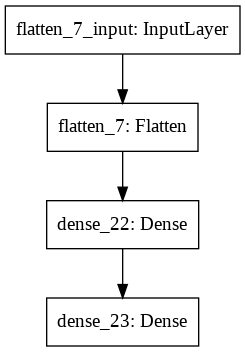

In [ ]:
model_forPlot = tf.keras.Sequential([
      tf.keras.layers.Flatten(input_shape=(28, 28)),
      tf.keras.layers.Dense(num_neurons, activation='relu'),
      tf.keras.layers.Dense(10, activation='softmax')])
plot_model(model_forPlot)

In [ ]:
model_forPlot.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_7 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_22 (Dense)             (None, 128)               100480    
_________________________________________________________________
dense_23 (Dense)             (None, 10)                1290      
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________


### Visualising the weights

**Result**:

From scatter plots, we can see weight changes before and
after the fit, but it hard to interpret.

From the violin graphs, before the fit, the weight does not 
form a particular distribution and has multi modals. After the fit, 
the weight is clearly forming a distribution with median around 0.2


/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


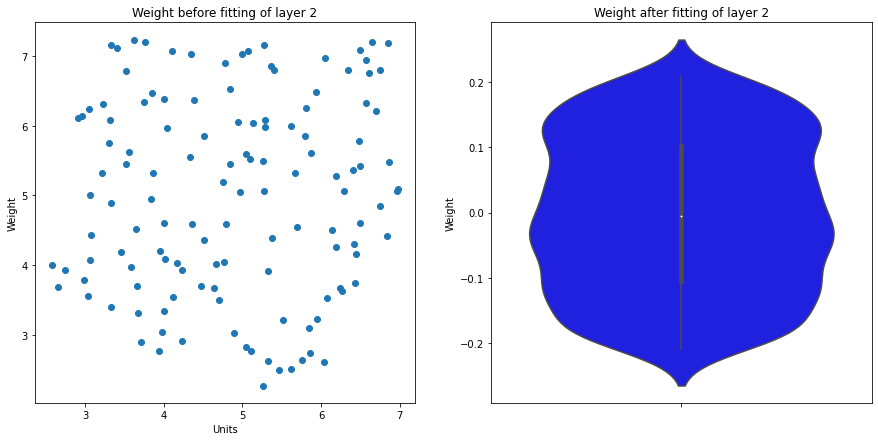

Epoch 1/10
422/422 - 1s - loss: 0.3834 - accuracy: 0.8946 - val_loss: 0.2083 - val_accuracy: 0.9418
Epoch 2/10
422/422 - 1s - loss: 0.1734 - accuracy: 0.9506 - val_loss: 0.1468 - val_accuracy: 0.9585
Epoch 3/10
422/422 - 1s - loss: 0.1245 - accuracy: 0.9649 - val_loss: 0.1230 - val_accuracy: 0.9637
Epoch 4/10
422/422 - 1s - loss: 0.0974 - accuracy: 0.9723 - val_loss: 0.0998 - val_accuracy: 0.9718
Epoch 5/10
422/422 - 1s - loss: 0.0775 - accuracy: 0.9781 - val_loss: 0.0930 - val_accuracy: 0.9737
Epoch 6/10
422/422 - 1s - loss: 0.0646 - accuracy: 0.9809 - val_loss: 0.0896 - val_accuracy: 0.9745
Epoch 7/10
422/422 - 1s - loss: 0.0542 - accuracy: 0.9847 - val_loss: 0.0784 - val_accuracy: 0.9775
Epoch 8/10
422/422 - 1s - loss: 0.0460 - accuracy: 0.9871 - val_loss: 0.0773 - val_accuracy: 0.9782
Epoch 9/10
422/422 - 1s - loss: 0.0383 - accuracy: 0.9891 - val_loss: 0.0724 - val_accuracy: 0.9788
Epoch 10/10
422/422 - 1s - loss: 0.0327 - accuracy: 0.9914 - val_loss: 0.0700 - val_accuracy: 0.9790

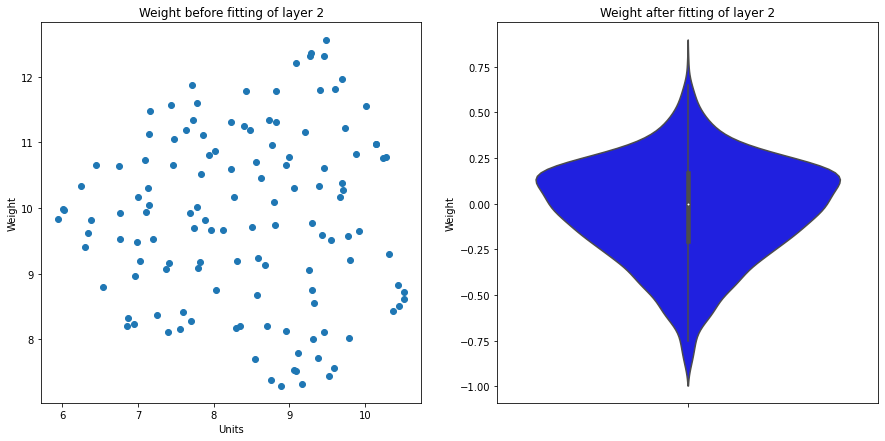

In [ ]:
# Compile model before visualising initial weight

# Basic model
model_weight = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

model_weight.compile(optimizer=get_optimizer(),
            loss='categorical_crossentropy',
            metrics=['accuracy'])
  
layer_idx = 2

visualise_weights (layer_idx, model_weight)

# Fit model then visualise weight
model_history = model_weight.fit(train_ds, batch_size=BATCH_SIZE, epochs=10, validation_data=val_ds, verbose=2)

visualise_weights (layer_idx, model_weight)



### Task 4.3 Check the training using TensorBoard

I use TensorBoard to visualise the training process. I saved the experiments in https://tensorboard.dev/experiment/LH3CdoV0Q6mmkckDSdnQpw/#scalars


I recorded gradients for a hidden layer and an output layer with training data using the basic model. It shows that gradients drop at early epoch and stabilize with small up and down changes. The result can be found here https://tensorboard.dev/experiment/DJD5yEJgTbKMApsNlgHOgw/

The function inherit from GradCallback. In the end of each epoch, get layers trainable weights. Use the training data, calculate loss and gradient. Calculate the means and plot it to tensorboard


In [ ]:
cd /content/drive/MyDrive/logs

/content/drive/MyDrive/logs


In [ ]:
# # Load the TensorBoard notebook extension
%reload_ext tensorboard

# # Open an embedded TensorBoard viewer
%tensorboard --logdir {logdir}

#Save TensorBoard
# !tensorboard dev upload --logdir {logdir} \
#   --name "Wellia 220093302" \
#   --description "Training gradients" \
#   --one_shot

In [ ]:
class GradCallback(tf.keras.callbacks.TensorBoard):
  def __init__ (self, logdir):
    super(GradCallback, self).__init__(log_dir= logdir, histogram_freq=1,
                                       write_graph=True, update_freq='epoch', profile_batch=2)

  def on_epoch_end(self, epoch, logs={}):
    file_writer = tf.summary.create_file_writer(logdir)
    tf.summary.trace_on(graph=True)

    super().on_epoch_end(epoch, logs)

    model = self.model
    layer1 = model.layers[0]
    layer2 = model.layers[1]
    layer3 = model.layers[2]

    with tf.GradientTape(persistent=True, watch_accessed_variables=True) as tape:
      tape.watch(model.trainable_weights)
      #sample, = train_ds.take(1)
      #image, label = sample[0], sample[1]
      image, label = X_train, y_train
      y_pred = self.model(image)  # forward-propagation
      loss = tf.keras.metrics.categorical_crossentropy(label, y_pred)

    grads = []
    grads.append(tape.gradient(loss, layer1.trainable_weights))
    grads.append(tape.gradient(loss, layer2.trainable_weights))
    grads.append(tape.gradient(loss, layer3.trainable_weights))

    tf.summary.experimental.set_step(epoch)

    #with self._train_writer.as_default():
    with file_writer.as_default():
        for i, g in enumerate(grads):
          if len(g) > 0:
            curr_grad = g[0]
            mean = tf.reduce_mean(tf.abs(curr_grad))
            tf.summary.scalar('grad_mean_layer_{}'.format(i+1), mean)
            tf.summary.histogram('grad_histogram_layer_{}'.format(i+1), curr_grad)

    #self._train_writer.flush()
    file_writer.flush()

In [ ]:
# test gradient
# Compile model before visualising initial weight

# Basic model
model_gradient = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

model_gradient.compile(optimizer=tf.keras.optimizers.Adam(),
            loss='categorical_crossentropy',
            metrics=['accuracy'])
  
# Fit model then visualise weight
model_gradient.fit(train_ds, batch_size=BATCH_SIZE, epochs=100, validation_data=val_ds, verbose=2, callbacks=GradCallback(logdir))


Epoch 1/100
422/422 - 2s - loss: 0.3881 - accuracy: 0.8914 - val_loss: 0.2122 - val_accuracy: 0.9395
Epoch 2/100
422/422 - 1s - loss: 0.1802 - accuracy: 0.9484 - val_loss: 0.1600 - val_accuracy: 0.9543
Epoch 3/100
422/422 - 1s - loss: 0.1311 - accuracy: 0.9621 - val_loss: 0.1294 - val_accuracy: 0.9613
Epoch 4/100
422/422 - 1s - loss: 0.1030 - accuracy: 0.9705 - val_loss: 0.1066 - val_accuracy: 0.9710
Epoch 5/100
422/422 - 1s - loss: 0.0837 - accuracy: 0.9761 - val_loss: 0.0979 - val_accuracy: 0.9718
Epoch 6/100
422/422 - 1s - loss: 0.0692 - accuracy: 0.9804 - val_loss: 0.0898 - val_accuracy: 0.9738
Epoch 7/100
422/422 - 1s - loss: 0.0585 - accuracy: 0.9832 - val_loss: 0.0836 - val_accuracy: 0.9760
Epoch 8/100
422/422 - 1s - loss: 0.0493 - accuracy: 0.9862 - val_loss: 0.0847 - val_accuracy: 0.9763
Epoch 9/100
422/422 - 1s - loss: 0.0415 - accuracy: 0.9887 - val_loss: 0.0780 - val_accuracy: 0.9777
Epoch 10/100
422/422 - 1s - loss: 0.0360 - accuracy: 0.9898 - val_loss: 0.0766 - val_accura

## Task 5 Overfitting and regularisation

**Overfitting on basic model**

With basic model, the result is slightly overfitting. The training accuracy increases to epoch 15 then stabilize. The validation accuracy increases sharply until epoch 5 then increases slowly to epoch 15 then stabilize. The training loss decreases to close to 0, the validation loss decreases until epoch 15 then slightly increases. The training stop at epoch 33 because I use EarlyStopping 
 
**Training with 200 examples**

With 200 examples, I saw an extreme overfitting. The training accuracy is 100% whereas the validation accuracy is 79%. The training loss is 0.0317 whereas val_loss is 0.6376. Training with few samples causes overfitting, the training does not have time to learn.

**Optimisation**

I combined manual optimisation and Keras Tuner. 

To find the best optimizer, I loop through different optimizer with it's default learning rate as follows: sgd: 1e-2, rmsprop: 1e-3, adagrad: 1e-2, adadelta: 1.0, adam: 1e-3, adamax: 2e-3, nadam:  2e-3

After running for 50 epochs. The best optimizer is SGD. This experiment was not successful. I implemented Adam optimizer in other experiments with good result. The only different is in this experiment I use a default learning rate instead of learning schedule that decreasing in every epoch. Therefore, I decided to use Adam for later experiments.

With keras tuner, I try to find the optimal dropOut rate and number of neuron in a hidden layer.

**Regularizations**

In my experiments, I performed the following:
1. I added dropout layer 
2. I added a Batch Normalisation
3. I added L2 regularisation
4. I have implemented a schedule learning rate in the basic model (Task 4.2)

**BatchNormalization**
As weight is updated between epoch during the trainning, sometimes weight becomes very large and can cause problem to the network. BatchNormalization stabilize the input values from one node to the next node.

**Dropout layer**
Dropout layers is regularization type to reduce the overfitting and improve the generalization. Dropout will randomly drop out outputs from a layer, making the training process noisy, forcing nodes within a layer to adapt and correct mistake from prior layers, then making the model more robust. Initially I put 0.2 as a dropout rate, it means it will keep 20% outputs.

**L2 Regularisation**
Another way to reduce the overfitting is to perform L2 regularization . It encourages the weight values towards zero, but not exactly zero


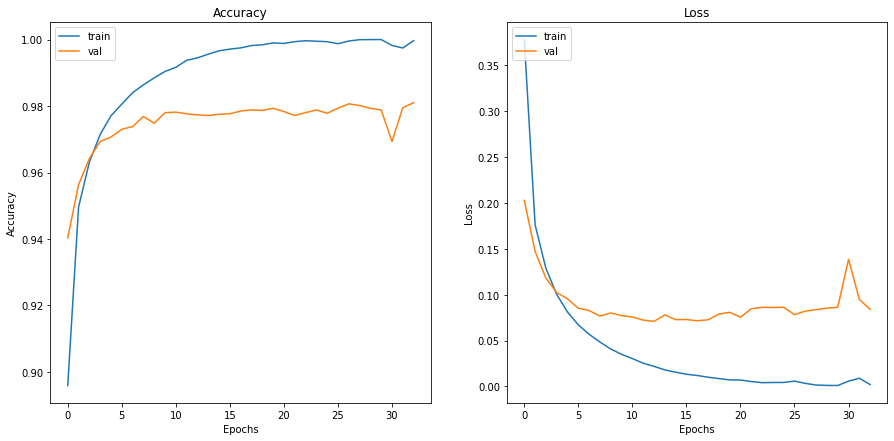

In [ ]:
plot_model_metric(histories['model_basic'])

In [ ]:
### Training with 200 examples, validation and test data are the same

batchSize200 = 64
X_train200 = X_train[:200]
y_train200 = y_train[:200]

train_ds200, val_ds200, test_ds200 = input_pipelines(X_train200, y_train200, X_val, y_val, X_test, y_test, batchSize200)

model_200 = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])
model_200 = compile_and_fit(model_200, 'model_200', optimizer=get_optimizer(), max_epochs=200, batchSize=batchSize200, trainDs = train_ds200)


Epoch 1/200
4/4 - 1s - loss: 2.3136 - accuracy: 0.1650 - val_loss: 2.0866 - val_accuracy: 0.2773
Epoch 2/200
4/4 - 0s - loss: 1.8637 - accuracy: 0.5100 - val_loss: 1.8443 - val_accuracy: 0.5148
Epoch 3/200
4/4 - 0s - loss: 1.5508 - accuracy: 0.7400 - val_loss: 1.6218 - val_accuracy: 0.6158
Epoch 4/200
4/4 - 0s - loss: 1.2837 - accuracy: 0.7900 - val_loss: 1.4255 - val_accuracy: 0.6662
Epoch 5/200
4/4 - 0s - loss: 1.0650 - accuracy: 0.8300 - val_loss: 1.2703 - val_accuracy: 0.6870
Epoch 6/200
4/4 - 0s - loss: 0.8832 - accuracy: 0.8600 - val_loss: 1.1494 - val_accuracy: 0.7050
Epoch 7/200
4/4 - 0s - loss: 0.7403 - accuracy: 0.8950 - val_loss: 1.0418 - val_accuracy: 0.7200
Epoch 8/200
4/4 - 0s - loss: 0.6218 - accuracy: 0.9100 - val_loss: 0.9520 - val_accuracy: 0.7338
Epoch 9/200
4/4 - 0s - loss: 0.5364 - accuracy: 0.9100 - val_loss: 0.8989 - val_accuracy: 0.7375
Epoch 10/200
4/4 - 0s - loss: 0.4750 - accuracy: 0.9250 - val_loss: 0.8439 - val_accuracy: 0.7445
Epoch 11/200
4/4 - 0s - loss:

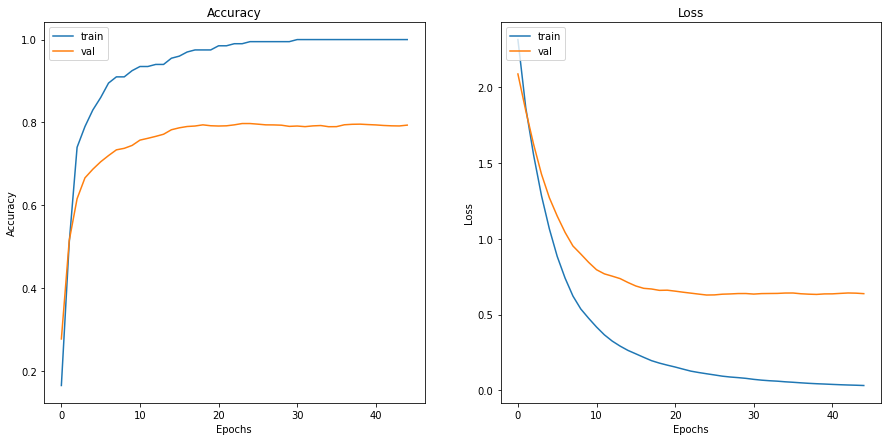

In [ ]:
plot_model_metric(model_200)

In [ ]:
### Experiments

In [ ]:
# Add batch normalisation

def run_model_batchNormalisation(max_epochs, num_neurons):
  print('\n=========== Model Batch Normalisation =============')
  model_batchNormalisation = tf.keras.Sequential([
      tf.keras.layers.Flatten(input_shape=(28, 28)),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.Dense(num_neurons, activation='relu'),
      tf.keras.layers.Dense(10, activation='softmax')
  ])

  adam_optimizer = tf.keras.optimizers.Adam(learning_rate=0.01) 
  histories['model_batchNormalisation'] = compile_and_fit(model_batchNormalisation, 'model_batchNormalisation', adam_optimizer, max_epochs=max_epochs)

In [ ]:
# Add initializer to the model

def run_model_initializer(max_epochs, num_neurons):
  print('\n=========== Model Initializer =============')

  model_initializer = tf.keras.Sequential([
      tf.keras.layers.Flatten(input_shape=(28, 28)),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.Dense(num_neurons, activation='relu', kernel_initializer='he_uniform'),
      tf.keras.layers.Dense(10, activation='softmax')
  ])

  adam_optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
  histories['model_initializer'] = compile_and_fit(model_initializer, 'model_initializer', adam_optimizer, max_epochs=max_epochs)

In [ ]:
# Add drop out layer
def run_model_dropOut(max_epochs, num_neurons):
  print('\n=========== Model Dropout =============')
  model_do = tf.keras.Sequential([
      tf.keras.layers.Flatten(input_shape=(28, 28)),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.Dense(num_neurons, activation='relu', kernel_initializer='he_uniform'),
      tf.keras.layers.Dropout(0.2),
      tf.keras.layers.Dense(10, activation='softmax')
  ])

  adam_optimizer = get_optimizer()
  histories['model_do'] = compile_and_fit(model_do, 'model_do', adam_optimizer, max_epochs=max_epochs)


In [ ]:
def run_experiments(max_epochs, num_neurons, run_id):
  run_model_batchNormalisation(max_epochs, num_neurons)
  run_model_initializer(max_epochs, num_neurons)
  run_model_dropOut(max_epochs, num_neurons)

# run for 200 epochs and 128 neurons
run_id = "200Epoch_128Neurons"
num_neurons = 128
max_epochs = 200
run_experiments(max_epochs, num_neurons, run_id)


=========== Model Batch Normalisation =============
Epoch 1/200
422/422 - 2s - loss: 0.2393 - accuracy: 0.9321 - val_loss: 0.1464 - val_accuracy: 0.9538
Epoch 2/200
422/422 - 1s - loss: 0.1312 - accuracy: 0.9628 - val_loss: 0.1421 - val_accuracy: 0.9623
Epoch 3/200
422/422 - 1s - loss: 0.1098 - accuracy: 0.9681 - val_loss: 0.1448 - val_accuracy: 0.9623
Epoch 4/200
422/422 - 1s - loss: 0.0948 - accuracy: 0.9723 - val_loss: 0.1604 - val_accuracy: 0.9655
Epoch 5/200
422/422 - 1s - loss: 0.0820 - accuracy: 0.9758 - val_loss: 0.1563 - val_accuracy: 0.9650
Epoch 6/200
422/422 - 1s - loss: 0.0848 - accuracy: 0.9761 - val_loss: 0.1243 - val_accuracy: 0.9700
Epoch 7/200
422/422 - 1s - loss: 0.0839 - accuracy: 0.9773 - val_loss: 0.1595 - val_accuracy: 0.9627
Epoch 8/200
422/422 - 1s - loss: 0.0856 - accuracy: 0.9776 - val_loss: 0.2452 - val_accuracy: 0.9660
Epoch 9/200
422/422 - 1s - loss: 0.0892 - accuracy: 0.9768 - val_loss: 0.1740 - val_accuracy: 0.9662
Epoch 10/200
422/422 - 1s - loss: 0.07

In [ ]:
optimizers = {
    'sgd':        'SGD',
    'rmsprop':    'RMSprop',
    'adagrad':    'Adagrad',
    'adadelta':   'Adadelta',
    'adam':       'Adam',
    'adamax':     'Adamax',
    'nadam':      'Nadam',
}

model_optimizer = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(10, activation='softmax')
])

for opt in optimizers:
  print('Optimizer: ', opt)
  optimizer_name = 'model_optimizer_' + opt
  histories[optimizer_name] = compile_and_fit(model_optimizer, optimizer_name, optimizer=opt, max_epochs=50)

Optimizer:  sgd
Epoch 1/50
422/422 - 2s - loss: 0.8437 - accuracy: 0.7476 - val_loss: 0.4295 - val_accuracy: 0.8855
Epoch 2/50
422/422 - 1s - loss: 0.4188 - accuracy: 0.8769 - val_loss: 0.3147 - val_accuracy: 0.9073
Epoch 3/50
422/422 - 1s - loss: 0.3529 - accuracy: 0.8950 - val_loss: 0.2727 - val_accuracy: 0.9198
Epoch 4/50
422/422 - 1s - loss: 0.3116 - accuracy: 0.9069 - val_loss: 0.2473 - val_accuracy: 0.9252
Epoch 5/50
422/422 - 1s - loss: 0.2908 - accuracy: 0.9131 - val_loss: 0.2281 - val_accuracy: 0.9295
Epoch 6/50
422/422 - 1s - loss: 0.2716 - accuracy: 0.9186 - val_loss: 0.2148 - val_accuracy: 0.9330
Epoch 7/50
422/422 - 1s - loss: 0.2572 - accuracy: 0.9225 - val_loss: 0.2044 - val_accuracy: 0.9375
Epoch 8/50
422/422 - 1s - loss: 0.2432 - accuracy: 0.9275 - val_loss: 0.1946 - val_accuracy: 0.9412
Epoch 9/50
422/422 - 1s - loss: 0.2337 - accuracy: 0.9301 - val_loss: 0.1878 - val_accuracy: 0.9425
Epoch 10/50
422/422 - 1s - loss: 0.2233 - accuracy: 0.9337 - val_loss: 0.1805 - val_

### Keras Tuner - Hyperparameter tunings

In [ ]:
# Building a model based on the recent model after experiments

def model_builder(hp):
  model = tf.keras.Sequential()

  # input layer
  model.add(tf.keras.layers.Flatten(input_shape=(28, 28)))
    
  model.add(tf.keras.layers.BatchNormalization())

  # First Dense layer, tune the number of units in this layer
  # model2 initially had 128 units, now we choose values between 128-512)
  hp_units = hp.Int('units', min_value=128, max_value=512, step=32)
  model.add(tf.keras.layers.Dense(units=hp_units, activation='relu', kernel_initializer='he_uniform'))

  # Dropout layer from 0 to 0.5. 0 is not output, 1 is no dropout
  hp_dropout = hp.Float('dropout', 0.2, 0.7, step=0.1, default=0.5)
  model.add(tf.keras.layers.Dropout(hp_dropout))

  # output layer
  model.add(tf.keras.layers.Dense(10, activation='softmax'))
 
  optimizer = get_optimizer()
  model.compile(optimizer=optimizer,
                loss='categorical_crossentropy',  #tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])
  
  return model

In [ ]:
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=30,
                     factor=3,
                     directory='tuner_dir',
                     project_name='assignment1_tuning')

INFO:tensorflow:Reloading Oracle from existing project tuner_dir/assignment1_tuning/oracle.json
INFO:tensorflow:Reloading Tuner from tuner_dir/assignment1_tuning/tuner0.json


In [ ]:
tuner.search(train_ds, epochs=50, validation_data=val_ds)
  
# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
        Best hyperparameters: \n
        Units in the first dense layer is {best_hps.get('units')}, \n
        Dropout rate is {best_hps.get('dropout')}
        """)


        Best hyperparameters: 

        Units in the first dense layer is 512, 

        Dropout rate is 0.4000000000000001
        


In [ ]:
# search result first dense layer is 448 and drop out 0.4

# Build the model with the optimal hyperparameters and train it on the data for 50 epochs
model_tuner = tuner.hypermodel.build(best_hps)
history = model_tuner.fit(train_ds, epochs=200, validation_data=val_ds)

val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Epoch 1/200
422/422 [==============================] - 2s 3ms/step - loss: 0.2769 - accuracy: 0.9150 - val_loss: 0.1223 - val_accuracy: 0.9653
Epoch 2/200
422/422 [==============================] - 1s 3ms/step - loss: 0.1286 - accuracy: 0.9609 - val_loss: 0.0887 - val_accuracy: 0.9718
Epoch 3/200
422/422 [==============================] - 1s 3ms/step - loss: 0.0924 - accuracy: 0.9715 - val_loss: 0.0835 - val_accuracy: 0.9747
Epoch 4/200
422/422 [==============================] - 1s 3ms/step - loss: 0.0733 - accuracy: 0.9768 - val_loss: 0.0734 - val_accuracy: 0.9780
Epoch 5/200
422/422 [==============================] - 1s 3ms/step - loss: 0.0632 - accuracy: 0.9795 - val_loss: 0.0704 - val_accuracy: 0.9780
Epoch 6/200
422/422 [==============================] - 1s 3ms/step - loss: 0.0519 - accuracy: 0.9835 - val_loss: 0.0647 - val_accuracy: 0.9798
Epoch 7/200
422/422 [==============================] - 1s 3ms/step - loss: 0.0459 - accuracy: 0.9848 - val_loss: 0.0732 - val_accuracy: 0.9795

In [ ]:
hypermodel = tuner.hypermodel.build(best_hps)

# Retrain the model
histories['hypermodel'] = hypermodel.fit(train_ds, epochs=best_epoch, validation_data=val_ds, callbacks=get_callbacks("Hypermodel"))


Epoch 1/105
422/422 [==============================] - 2s 4ms/step - loss: 0.2829 - accuracy: 0.9139 - val_loss: 0.1217 - val_accuracy: 0.9647
Epoch 2/105
422/422 [==============================] - 1s 3ms/step - loss: 0.1286 - accuracy: 0.9607 - val_loss: 0.0954 - val_accuracy: 0.9730
Epoch 3/105
422/422 [==============================] - 1s 3ms/step - loss: 0.0928 - accuracy: 0.9706 - val_loss: 0.0807 - val_accuracy: 0.9768
Epoch 4/105
422/422 [==============================] - 1s 3ms/step - loss: 0.0721 - accuracy: 0.9771 - val_loss: 0.0747 - val_accuracy: 0.9778
Epoch 5/105
422/422 [==============================] - 1s 3ms/step - loss: 0.0603 - accuracy: 0.9806 - val_loss: 0.0782 - val_accuracy: 0.9793
Epoch 6/105
422/422 [==============================] - 1s 3ms/step - loss: 0.0505 - accuracy: 0.9830 - val_loss: 0.0693 - val_accuracy: 0.9817
Epoch 7/105
422/422 [==============================] - 1s 3ms/step - loss: 0.0446 - accuracy: 0.9854 - val_loss: 0.0632 - val_accuracy: 0.9830

In [ ]:
eval_result = hypermodel.evaluate(X_test, y_test)
print("[test loss, test accuracy]:", eval_result)

313/313 [==============================] - 1s 2ms/step - loss: 0.1100 - accuracy: 0.9811
[test loss, test accuracy]: [0.11002057045698166, 0.9811000227928162]


In [ ]:
# best model - use hypermodel configuration, increase the dropout from 0.4 to 0.6
model_best = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(512, activation='relu', kernel_initializer='he_uniform'),
    tf.keras.layers.Dropout(0.6),
    tf.keras.layers.Dense(10, activation='softmax')
])

adam_optimizer = get_optimizer()
histories['model_best'] = compile_and_fit(model_best, 'model_best', adam_optimizer, max_epochs=200)

Epoch 1/200
422/422 - 2s - loss: 0.3870 - accuracy: 0.8846 - val_loss: 0.1400 - val_accuracy: 0.9617
Epoch 2/200
422/422 - 1s - loss: 0.1872 - accuracy: 0.9432 - val_loss: 0.1054 - val_accuracy: 0.9703
Epoch 3/200
422/422 - 1s - loss: 0.1397 - accuracy: 0.9566 - val_loss: 0.0876 - val_accuracy: 0.9725
Epoch 4/200
422/422 - 1s - loss: 0.1161 - accuracy: 0.9648 - val_loss: 0.0836 - val_accuracy: 0.9763
Epoch 5/200
422/422 - 1s - loss: 0.1016 - accuracy: 0.9677 - val_loss: 0.0734 - val_accuracy: 0.9777
Epoch 6/200
422/422 - 1s - loss: 0.0925 - accuracy: 0.9712 - val_loss: 0.0690 - val_accuracy: 0.9802
Epoch 7/200
422/422 - 1s - loss: 0.0843 - accuracy: 0.9734 - val_loss: 0.0708 - val_accuracy: 0.9793
Epoch 8/200
422/422 - 1s - loss: 0.0766 - accuracy: 0.9766 - val_loss: 0.0659 - val_accuracy: 0.9808
Epoch 9/200
422/422 - 1s - loss: 0.0720 - accuracy: 0.9766 - val_loss: 0.0661 - val_accuracy: 0.9815
Epoch 10/200
422/422 - 1s - loss: 0.0671 - accuracy: 0.9778 - val_loss: 0.0622 - val_accura

In [ ]:
eval_result = model_best.evaluate(X_test, y_test)
print("[test loss, test accuracy]:", eval_result)

313/313 [==============================] - 1s 2ms/step - loss: 0.1201 - accuracy: 0.9813
[test loss, test accuracy]: [0.12010356783866882, 0.9812999963760376]


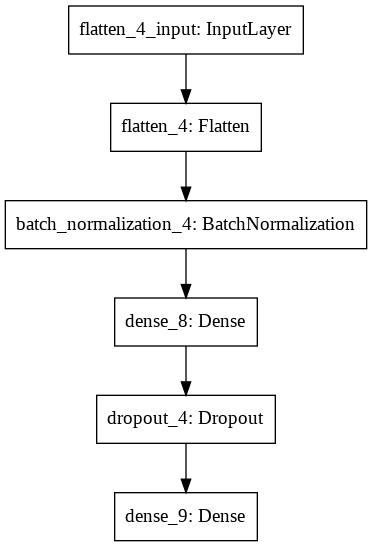

In [ ]:
model_best_forPlot = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(512, activation='relu', kernel_initializer='he_uniform'),
    tf.keras.layers.Dropout(0.6),
    tf.keras.layers.Dense(10, activation='softmax')
])
plot_model(model_best_forPlot)

In [ ]:
model_best_forPlot.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_4 (Flatten)          (None, 784)               0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 784)               3136      
_________________________________________________________________
dense_8 (Dense)              (None, 512)               401920    
_________________________________________________________________
dropout_4 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 10)                5130      
Total params: 410,186
Trainable params: 408,618
Non-trainable params: 1,568
_________________________________________________________________


In [ ]:
# Add L2 to the hypermodel configuration
# result: reduce train accuracy and add overfit
model_l2 = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(512, activation='relu', kernel_regularizer='l2'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(10, activation='softmax')
])

adam_optimizer = get_optimizer() 
histories['model_l2'] = compile_and_fit(model_l2, 'model_l2', adam_optimizer, max_epochs=200)

Epoch 1/200
422/422 - 2s - loss: 1.1172 - accuracy: 0.8794 - val_loss: 0.4658 - val_accuracy: 0.9218
Epoch 2/200
422/422 - 1s - loss: 0.4798 - accuracy: 0.9151 - val_loss: 0.4156 - val_accuracy: 0.9372
Epoch 3/200
422/422 - 1s - loss: 0.4442 - accuracy: 0.9227 - val_loss: 0.3895 - val_accuracy: 0.9408
Epoch 4/200
422/422 - 1s - loss: 0.4246 - accuracy: 0.9270 - val_loss: 0.3708 - val_accuracy: 0.9438
Epoch 5/200
422/422 - 1s - loss: 0.4084 - accuracy: 0.9308 - val_loss: 0.3722 - val_accuracy: 0.9397
Epoch 6/200
422/422 - 1s - loss: 0.4030 - accuracy: 0.9324 - val_loss: 0.3673 - val_accuracy: 0.9403
Epoch 7/200
422/422 - 1s - loss: 0.3885 - accuracy: 0.9345 - val_loss: 0.3492 - val_accuracy: 0.9460
Epoch 8/200
422/422 - 1s - loss: 0.3805 - accuracy: 0.9367 - val_loss: 0.3327 - val_accuracy: 0.9540
Epoch 9/200
422/422 - 1s - loss: 0.3771 - accuracy: 0.9367 - val_loss: 0.3430 - val_accuracy: 0.9467
Epoch 10/200
422/422 - 1s - loss: 0.3705 - accuracy: 0.9383 - val_loss: 0.3293 - val_accura

In [ ]:
import pandas as pd

print('Experiment results (accuracy %, loss in decimals)')
df = pd.read_csv('result.csv')
df

Experiment results (accuracy %, loss in decimals)


,model,accuracy,val_accuracy,loss,val_loss,num_of_neurons,Learning Schedule,Dropout,BatchNormalization,He Initializer
0,model_basic,99.97,98.10,0.002,0.084,128,Y,N,N,Y
1,model_batchNormalisation,98.79,96.62,0.074,0.346,128,Y,N,Y,Y
2,model_initializer,98.53,97.05,0.072,0.265,128,Y,N,Y,Y
3,model_do,99.31,98.12,0.020,0.093,128,Y,0.2,Y,Y
4,model_optimizer_sgd,96.84,97.00,0.105,0.097,128,Y,0.2,Y,Y
5,model_optimizer_rmsprop,99.10,97.98,0.029,0.117,128,Y,0.2,Y,Y
6,model_optimizer_adagrad,99.39,98.33,0.019,0.101,128,Y,0.2,Y,Y
7,model_optimizer_adadelta,99.38,98.32,0.018,0.101,128,Y,0.2,Y,Y
8,model_optimizer_adam,99.43,98.15,0.018,0.113,128,Y,0.2,Y,Y
9,model_optimizer_adamax,99.74,98.35,0.008,0.111,128,Y,0.2,Y,Y



### Summary

This is the best configuration:
- Sequential model with the following configuration:
- layers.Flatten(input_shape=(28, 28))
- layers.BatchNormalization()
- layers.Dense(512, activation='relu', kernel_initializer='he_uniform')
- layers.Dropout(0.6)
- layers.Dense(10, activation='softmax')

The model implemented adam_optimizer, categorical_crossentropy loss, accuracy metric, epoch=30, batch=128

Adding dropout layer has the **most** impact in regularisation. Adding batchNormalization has the **least** impact. BatchNormalization is suggested to prevent the weight imbalanced, probably it is not necessary in the case working with standard and small dataset such as MNIST

Simple basic model performs fairly well, only slighly overfitting. 

Training with 200 samples causes overfitting. Network does not have time to learn with few samples.

Model with L2 Regularization reduces overfitting, but the model with L2 has higher loss and lower accuracy comparing with other models. In my case, dropout is better for regularization than L2. Dropout forces network to learn by randomly dropping out outputs. 

Hyperparameter successfully found the optimal parameter for number of a hidden neurons and dropout value

Based on hyperparameter model, I created the best model and evalute it using test data. The result is test loss is 0.12 and accuracy is 98%

Most experiments are converged, the accuracy peaks then stabilize at the top level. 

## Task 6 Generate HTML output

Use *nbconvert* to convert the notebook into an HTML file

###References:

https://www.tensorflow.org/

https://keras.io/examples/

https://stackoverflow.com/ questions

https://machinelearningmastery.com/

https://medium.com/@leenabora1/how-to-keep-a-track-of-gradients-vanishing-exploding-gradients-b0bbaa1dcb93

Lecture slides and workshops

---
**END OF ASSIGNMENT ONE**

